In [ ]:
from openpyxl import load_workbook
from scipy import io # load .mat file

## Load Modules

In [1]:
# Signal Preprocessing Methods
from preprocessModule import *

# Transform preprocessed signal into an input formation
from transformModule import *

# Plot methods for various input data
from plotModule import *

# 1. DEAP Dataset

### DEAP Dataset Description
* __32 participants__
* __40 clips__ for each participant
* Evaluation : __Valence, Arousal, Dominance, Like__ (1 to 9)

### Setting & Initialization

In [2]:
DEAP_channels = {"FP1":0, "AF3":1, "F3":2, "F7":3,
                 "FC5":4, "FC1":5, "C3":6, "T7":7,
                 "CP5":8, "CP1":9, "P3":10,
                 "P7":11, "PO3":12, "O1":13, 
                 "OZ":14, "PZ":15, "FP2":16, 
                 "AF4":17, "FZ":18, "F4":19,
                 "F8":20, "FC6":21, "FC2":22,
                 "CZ":23, "C4":24, "T8":25,
                 "CP6":26, "CP2":27, "P4":28,
                 "P8":29, "PO4":30, "O2":31}

DEAP_all_channel_names = list(DEAP_channels.keys())
DEAP_all_channel_values = list(DEAP_channels.values())

In [6]:
# Initialization ============================
# Label list
label_list = [] # list of tuple (V,A,D,L)

# Input list 
fftMap_list = [] # Fast Fourier Transform Map
base_fftMap_list = [] # base(3sec) fft map list

fd_list = [] # FD pattern
base_fd_list = [] 
# ===========================================

# Parameters ===============================
freqs = [freq for freq in range(4,46,1)]
chosen_channels = DEAP_all_channel_values
# openBCI default channels
#chosen_channels = [0, 16, 6, 24, 11, 20, 13, 31] # ["FP1", "FP2", "C3", "C4", "P7", "P8", "O1", "O2"]

sf = 128 
chunk_size = 10 * sf
overlap = 5 * sf
# ==========================================

### Traverse Dataset

In [7]:
import time
import pickle

eeg_path = "EEG dataset/DEAP/physiological_recordings/data_preprocessed_python/data_preprocessed_python/"

# [ Loop 1 ] 32 Participants
for participant_id in range(1, 33):
    file_name = "s" + str(int(participant_id/10)) + str(participant_id%10) + ".dat"
    s = pickle.load(open(eeg_path + file_name, 'rb'), encoding='latin1')
    
    labels = s['labels']
    data = s['data']
    
    # [ Loop 2 ] 40 Trials
    for trial_id in range(0, 40):      
        # label 
        V, A, D, L = labels[trial_id]
        
        base_signal = data[trial_id][:, :sf * 3] # 3sec
        total_signal = data[trial_id][:, sf * 3:] # 60sec
        
        # all_chunks = [[start//sf, (start+chunk_size)//sf] for start in range(0, sf*60-chunk_size+1, chunk_size-overlap)]
        # print("Total %d chunks",%(len(all_chunks))); print(all_chunks)
        
        all_chunks = [total_signal[:, start:start+chunk_size] 
                     for start in range(0, sf*60-chunk_size+1, chunk_size-overlap)]
        
        # processing base signal==================================
        base_fftMap = computefftMap(base_signal, chosen_channels, freqs, sf)
        base_fftMap_list.append(base_fftMap)
        base_fd = computeFD(base_signal, chosen_channels)
        base_fd_list.append(base_fd)
        # ========================================================
        
        # [ Loop 3 ] Sliding window
        for chunk in all_chunks:
            # fftMap (2d array) ======================
            fftMap = computefftMap(chunk, chosen_channels, freqs, sf)    
            fftMap_list.append(fftMap)
            # ========================================
            # FD pattern (1d array)====================
            fd = computeFD(chunk, chosen_channels)
            fd_list.append(fd)
            # =========================================
            label_list.append((V,A,D,L))
    print("Participant %d Ended"%(participant_id))
    print(time.strftime('%c', time.localtime(time.time())))

/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pyeeg-0.4.4-py3.6.egg/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Participant 1 Ended
Wed Apr 22 17:02:17 2020


KeyboardInterrupt: 

In [9]:
test_signal = data[trial_id][:, sf * 3:] # 60sec
all_chunks = [test_signal[:, start:start+chunk_size] 
            for start in range(0, sf*60-chunk_size+1, chunk_size-overlap)]
test_chunk = all_chunks[0]

test_fftMap = fftMap_list[0]

Text(0, 0.5, 'Intensity')

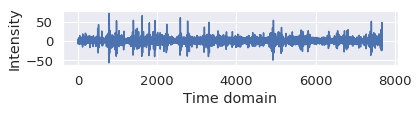

In [47]:
import seaborn as sns

sns.set(font_scale = 1.2)
plt.figure(figsize=(6,1))
plt.plot(test_signal[2])
plt.xlabel('Time domain')
plt.ylabel("Intensity")

Text(0, 0.5, 'Amplitude')

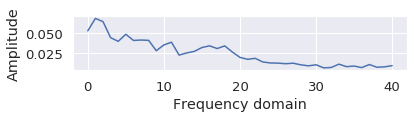

In [51]:
plt.figure(figsize=(6,1))
plt.plot(test_fftMap[5])
plt.xlabel('Frequency domain')
plt.ylabel("Amplitude")

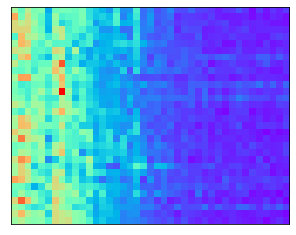

In [10]:
show_image(test_fftMap)

In [364]:
noc = len(fftMap_list) // 1280 # num of chunks
len(label_list) == len(fftMap_list) # True

True

### Save

In [266]:
def get_data_index(p_id, t_id, c_id, noc):
    return (noc * 40) * p_id + noc * t_id + c_id

def get_base_index(p_id, t_id):
    return 40 * p_id + t_id

# get p_id, t_id, c_id
def from_data_index(index, noc):
    # return index//40, index%40
    p_id,remain = index // (noc*40), index % (noc*40)
    return p_id, remain//noc, remain%noc

In [337]:
data_list = []
save_option = "origin" # "diff"

for i in range(len(fftMap_list)):
    # activated signals (60sec)
    if save_option == "origin":
        data_list.append([fftMap_list[i], label_list[i]]) # **
        
    # 60sec(activate) - 3sec(base)
    elif save_option == "diff":
        p_id, t_id, c_id = from_data_index(i)
        base_index = get_base_index(p_id, t_id)
        
        diff = np.array(scale(fd_list[i])) - np.array(scale(base_fd_list[base_index]))
        data_list.append([diff, label_list[i]])

In [338]:
with open('DEAP_fftMap_10sec_5over.pickle', 'wb') as f:
    pickle.dump(data_list, f, pickle.HIGHEST_PROTOCOL)

# 2. SEED dataset

### SEED dataset Description

* 15 Participants
* 3 Experiment for each participant
* 15 Trial clips for each experiment
    * Trial clips (total 15)
        * Sad(0) : Aftershock(2), Back to 1942(3)
        * Neutral(1) : World Geritage in China(5)
        * Happy(2) : Lost in Thailand(2), Flirting Scholar, Just Another Pandora's Box(2) 
    * Trial selection criteria
        1. not too long (about 4 min)
        2. should elicit a single desired target emotion
        3. should be understood without explanation
* Experiment process
    * 5 sec base => 4 min trial => 45 sec self-assessment => 15 sec rest
* Preprocessing
    * downsampled to 200Hz
    * 0 ~ 75Hz bandpass filtering
* Total 45(=3 experiments x 15 participants) .mat files
    * one .mat file for each experiment
    * 16 arrays
        * 15 arrays : preprocessed EEG data of 15 trials
            * shape = (channel x data)
        * 1 arrays : Labels
            * -1 : negative
            * 0 : neutral
            * 1 : positive
    

### Load meta data

In [1]:
from scipy import io # load .mat file
from openpyxl import load_workbook

channel_path = "EEG dataset/SEED/Channel Order.xlsx"
ch_file = load_workbook(channel_path, data_only=True)

SEED_channels = {}

for ch_idx in range(1, 63): # 1 to 62
    SEED_channels[ch_file["Sheet1"][ch_idx][0].value] = ch_idx-1

SEED_all_channel_names = list(SEED_channels.keys())
SEED_all_channel_values = list(SEED_channels.values())

/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import os
from collections import defaultdict

eeg_path = "EEG dataset/SEED/Preprocessed_EEG/"

filename_dict = defaultdict(list)

for file in os.listdir(eeg_path):
    filename_dict[int(file.split('_')[0])].append(file)

In [3]:
filename_dict

defaultdict(list,
            {1: ['1_20131107.mat', '1_20131030.mat', '1_20131027.mat'],
             4: ['4_20140702.mat', '4_20140705.mat', '4_20140621.mat'],
             7: ['7_20131030.mat', '7_20131027.mat', '7_20131106.mat'],
             12: ['12_20131207.mat', '12_20131127.mat', '12_20131201.mat'],
             8: ['8_20140514.mat', '8_20140521.mat', '8_20140511.mat'],
             10: ['10_20131204.mat', '10_20131130.mat', '10_20131211.mat'],
             2: ['2_20140419.mat', '2_20140404.mat', '2_20140413.mat'],
             3: ['3_20140611.mat', '3_20140629.mat', '3_20140603.mat'],
             11: ['11_20140618.mat', '11_20140630.mat', '11_20140625.mat'],
             14: ['14_20140627.mat', '14_20140601.mat', '14_20140615.mat'],
             9: ['9_20140627.mat', '9_20140704.mat', '9_20140620.mat'],
             15: ['15_20131105.mat', '15_20130709.mat', '15_20131016.mat'],
             5: ['5_20140506.mat', '5_20140418.mat', '5_20140411.mat'],
             13: ['13_2014

In [4]:
trial_labels = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

### Initialization

In [5]:
# Initialization ============================
# Label list
label_list = [] # -1, 0, 1

# Input list 
fftMap_list = [] # list of 2d-array
base_fftMap_list = [] # base(5 sec) fft map list

fd_list = []
base_fd_list = [] 
# ===========================================

# Parameters ===============================
sf = 200
chunk_size = 10 * sf
overlap = 5 * sf

freqs = [freq for freq in range(4,46,1)]

chosen_channels = SEED_all_channel_values # SEED channels
# chosen_channels = [0, 16, 6, 24, 11, 20, 13, 31] # ["FP1", "FP2", "C3", "C4", "P7", "P8", "O1", "O2"]
# chosen_channels = [] # DEAP channels 
# for ch in DEAP_all_channel_names:
#     chosen_channels.append(SEED_channels[ch])
# ==========================================

In [6]:
import time

# index data
ptc_to_idx = {} # key : "participantID-trialID-chunkID", value : index
idx_to_ptc = [] # index => participantID-trialID-chunkID

idx = 0

# [ loop 1 ] : Participants
for p_id in range(0, 15): # 1 to 15
    experiment = io.loadmat(eeg_path + filename_dict[p_id+1][0])
    
    # [ loop 2 ] : Trials
    t_id = 0
    keys = list(experiment.keys())[3:] 
    for t_id in range(0, 15): 
        signal = experiment[keys[t_id]]
        # ==============================================
        # 2. split signal
        base_signal = signal[:, :sf * 5] 
        total_signal = signal[:, sf * 5:] 
        
        sig_len = total_signal.shape[1]//sf
        
        # all_chunks = [[start//sf, (start+chunk_size)//sf] 
        #     for start in range(0, sf*sig_len - chunk_size + 1, chunk_size-overlap)]
        # print("Total %d chunks",%(len(all_chunks))); print(all_chunks)
        
        all_chunks = [total_signal[:, start:start+chunk_size] 
                     for start in range(0, sf*sig_len - chunk_size + 1, chunk_size-overlap)]
        
        label = trial_labels[t_id]
        # ==============================================
        
        # [ loop 3 ] : Chunks
        c_id = 0
        for chunk in all_chunks: 
            ptc_to_idx[str(p_id)+"-"+str(t_id)+"-"+str(c_id)] = idx
            idx_to_ptc.append((p_id,t_id,c_id))
            idx += 1; c_id += 1
            
            # Compute FFT Map =========================
            fftMap = computefftMap(chunk, chosen_channels, freqs, sf)
            fftMap_list.append(fftMap)
            # ========================================
            
            # Compute FD pattern (1d array)============
            fd = computeFD(chunk, chosen_channels)
            fd_list.append(fd)
            # =========================================
            label_list.append(label)
    print("Pariticipant %d Ended"%(p_id))
    print(time.strftime('%c', time.localtime(time.time())))

Pariticipant 0 Ended
Mon Apr 27 20:09:57 2020
Pariticipant 1 Ended
Mon Apr 27 20:09:58 2020
Pariticipant 2 Ended
Mon Apr 27 20:10:00 2020
Pariticipant 3 Ended
Mon Apr 27 20:10:02 2020
Pariticipant 4 Ended
Mon Apr 27 20:10:04 2020
Pariticipant 5 Ended
Mon Apr 27 20:10:05 2020
Pariticipant 6 Ended
Mon Apr 27 20:10:07 2020
Pariticipant 7 Ended
Mon Apr 27 20:10:09 2020
Pariticipant 8 Ended
Mon Apr 27 20:10:11 2020
Pariticipant 9 Ended
Mon Apr 27 20:10:12 2020
Pariticipant 10 Ended
Mon Apr 27 20:10:14 2020
Pariticipant 11 Ended
Mon Apr 27 20:10:16 2020
Pariticipant 12 Ended
Mon Apr 27 20:10:17 2020
Pariticipant 13 Ended
Mon Apr 27 20:10:19 2020
Pariticipant 14 Ended
Mon Apr 27 20:10:21 2020


In [ ]:
len(fd_list)==len(label_list)

### Save

In [40]:
def get_data_index(p_id, t_id, c_id, noc=0):
    return ptc_to_idx[str(p_id) + "-" + str(t_id) + "-" + str(c_id)]
def get_base_index(p_id, t_id):
    return 15 * p_id + t_id
# get p_id, t_id, c_id
def from_data_index(index, noc=0):
    return idx_to_ptc[index]

In [ ]:
data_list = []
save_option = "origin" # "diff"

for i in range(len(label_list)):
    # activated signals
    if save_option == "origin":
        data_list.append([fftMap_list[i], label_list[i]])        
    # difference between activated and base signal
    elif save_option == "diff":
        p_id, t_id, c_id = from_data_index(i, noc)
        base_index = get_base_index(p_id, t_id)
        
        diff = np.array(scale(fftMap_list[i])) - np.array(scale(base_fftMap_list[base_index]))
        data_list.append([diff, label_list[i]])

In [15]:
import pickle

with open('SEED_fftMap_10sec_5over.pickle', 'wb') as f:
    pickle.dump(data_list, f, pickle.HIGHEST_PROTOCOL)
    
with open("SEED_10sec_5over_ptc_to_idx", 'wb') as f:
    pickle.dump(ptc_to_idx, f, pickle.HIGHEST_PROTOCOL)

with open("SEED_10sec_5over_idx_to_ptc", 'wb') as f:
    pickle.dump(idx_to_ptc, f, pickle.HIGHEST_PROTOCOL)

# 3. Manually collected data (from openBCI sensors)

* 신호 전처리

In [3]:
def read_signal_from_txt(path):
    f = open(path,'r')

    sf = 256
    signal = []

    while True:
        line = f.readline()
        if not line: break
        if line[0] == "%" : continue

        values = [float(val.strip(',')) for val in line.split()[1:9]]
        
        if len(values) == 8 and values[0] != 0:   
            signal.append(values)
            
    signal = np.array(signal)
    totalTime = len(signal)//sf

    signal = signal[1:sf*totalTime+1] 
    signal = np.transpose(signal)

    f.close()
    return signal

In [4]:
# Parameters ==================================
n_ch = 8
chosen_channels = [i for i in range(0, n_ch)]

sf = 256
chunk_size = 6 * sf 
overlap = 5 * sf

freqs = [freq for freq in range(4,46,1)]
# =============================================


# preprocessing ===============================
down_sample_allow = True
if down_sample_allow: sf = sf//2
filter_allow = True
# =============================================


# Initialization ==============================
# index data
ptc_to_idx = {} # key : "participantID-trialID-chunkID", value : index
idx_to_ptc = [] # index => participantID-trialID-chunkID

# data list
fftMap_list = []
label_list = [] 
# =============================================

신호 전처리 테스트

(8, 25600)
다운샘플링
필터링


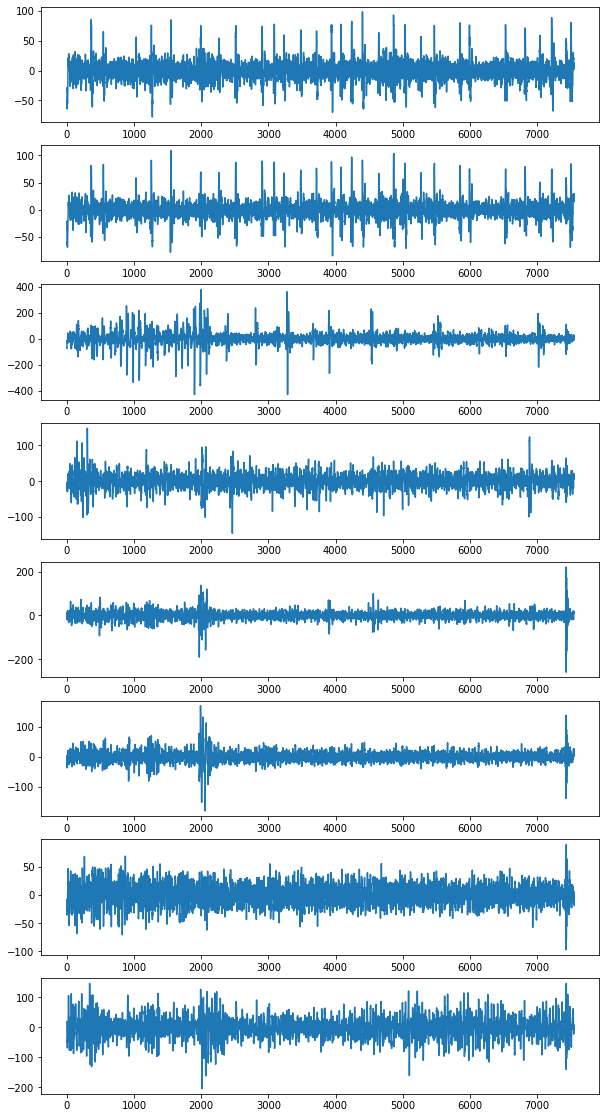

In [36]:
sf = 256 
total_signal = read_signal_from_txt("EEG dataset/openBCI/연지_1일/neutral_55_폭포.txt")
test_signal = copy.deepcopy(total_signal)

print(test_signal.shape)

down_sample_allow = True
filter_allow = True

# 1. down sampling
if down_sample_allow:
    print("다운샘플링")
    sf = sf//2
    test_signal = down_sampling(test_signal, chosen_channels)

# 2. filtering 
if filter_allow : 
    print("필터링")
    test_signal = filtering(test_signal, sf, chosen_channels)

plt.figure(figsize=(10,20))

for ch in chosen_channels:
    plt.subplot(810+ch+1)
    plt.plot(test_signal[ch, sf:sf*60])

In [37]:
import os

root = "EEG dataset/openBCI/"
dirs = os.listdir(root)

idx = 0
p_id = 0

# [ Loop 1 ] Participant
for directory in dirs:
    t_id = 0 # 영상마다 고유 trial id 주는건 일단은 무리.. 구색만 맞추자
    participant = directory.split("_")[0]
    if participant == "skip": continue
    print("P_id =", p_id, participant)
    files = os.listdir(root + directory)
    
    # [ Loop 1 ] Trial 
    for file_name in files:
        emo, VA, trial = file_name.split("_")
        V, A = int(VA[0]), int(VA[1])
        trial = trial[:-4]
        if emo == "fear":continue
        
        print("Emotion = %s, Valence = %d, Arousal = %d, Trial = %s"%(emo, V, A, trial))
        total_signal = read_signal_from_txt(root + directory + "/" + file_name)
        total_signal = total_signal[:,sf*5:] # 초반 5초 제거
        
        # preprocessing =============================
        test_signal = copy.deepcopy(total_signal)
        # 1. down sampling
        if down_sample_allow:
            test_signal = down_sampling(test_signal, chosen_channels)
        # 2. bandpass filter, notch filter
        if filter_allow:
            test_signal = filtering(test_signal, sf, chosen_channels)
        total_signal = test_signal
        # ===========================================
        sig_len = total_signal.shape[1]//sf

        all_chunks = [total_signal[:, start:start+chunk_size] 
            for start in range(0, sf*sig_len-chunk_size+1, chunk_size-overlap)]
        
        c_id = 0
        # [ Loop 3 ] Chunk
        for chunk in all_chunks:
            ptc_to_idx[str(p_id)+"-"+str(t_id)+"-"+str(c_id)] = idx
            idx_to_ptc.append((p_id,t_id,c_id))
            idx +=1; c_id += 1
            
            fftMap = computefftMap(chunk, chosen_channels, freqs, sf)
            fftMap_list.append(fftMap)
            
            label_list.append(emo)
        t_id += 1
    p_id += 1

P_id = 0 경진님
Emotion = happy, Valence = 7, Arousal = 7, Trial = 강아지털
Emotion = neutral, Valence = 5, Arousal = 4, Trial = 폭포
Emotion = neutral, Valence = 6, Arousal = 6, Trial = 신과함께
P_id = 1 명희님
Emotion = happy, Valence = 6, Arousal = 8, Trial = 공포영화모음
Emotion = happy, Valence = 8, Arousal = 7, Trial = 강아지털
Emotion = neutral, Valence = 6, Arousal = 3, Trial = 폭포
P_id = 2 소정님
Emotion = disgust, Valence = 1, Arousal = 8, Trial = 피지
Emotion = happy, Valence = 7, Arousal = 9, Trial = 강아지
Emotion = neutral, Valence = 3, Arousal = 4, Trial = 공포영화
Emotion = neutral, Valence = 4, Arousal = 2, Trial = 폭포
Emotion = sad, Valence = 4, Arousal = 8, Trial = 신과함께
P_id = 3 아빠
Emotion = disgust, Valence = 1, Arousal = 8, Trial = 피지
Emotion = happy, Valence = 5, Arousal = 5, Trial = 공포영화모음
Emotion = neutral, Valence = 5, Arousal = 8, Trial = 강아지털
Emotion = neutral, Valence = 8, Arousal = 3, Trial = 폭포
Emotion = sad, Valence = 2, Arousal = 8, Trial = 신과함께
P_id = 4 연지
Emotion = disgust, Valence = 3, Arou

In [38]:
print(len(label_list))
len(label_list) == len(fftMap_list)

1930


True

1930


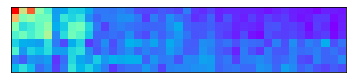

In [48]:
print(len(fftMap_list))
p_id = 7
t_id = 2
c_id = 17
show_image(fftMap_list[get_data_index(p_id, t_id, c_id)])

### save

In [710]:
def get_data_index(p_id, t_id, c_id, noc=0):
    return ptc_to_idx[str(p_id) + "-" + str(t_id) + "-" + str(c_id)]

# get p_id, t_id, c_id
def from_data_index(index, noc=0):
    return idx_to_ptc[index]

In [50]:
data_list = []

for i in range(len(label_list)):
    data_list.append([fftMap_list[i], label_list[i]])        

In [51]:
import pickle

with open('InputData/BCI_fftMap_6sec_5over.pickle', 'wb') as f:
    pickle.dump(data_list, f, pickle.HIGHEST_PROTOCOL)
    
with open("InputData/BCI_6sec_5over_ptc_to_idx", 'wb') as f:
    pickle.dump(ptc_to_idx, f, pickle.HIGHEST_PROTOCOL)

with open("InputData/BCI_6sec_5over_idx_to_ptc", 'wb') as f:
    pickle.dump(idx_to_ptc, f, pickle.HIGHEST_PROTOCOL)